In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
import piecewise_regression
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import plot_tree
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RationalQuadratic, Matern
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import shap
import warnings          #ignore warnings
warnings.filterwarnings("ignore")
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv('propertydata20240927tillbatch37nov21.csv')
df

,Name,Auto,Heating,Concentration,Batch,Sample,Trial,Thickness,Elastic Modulus,Yield Strength,Creep Strain,Plateau Slope,Densification Slope,Changepoint,Fit,Average Standard Deviation
0,Auto_noheating_10wt_3_1_1,True,False,10.00,3,1,1,109.0000,76.728733,8.035941,NaN,40.371877,990.455813,0.728571,True,53.797772
1,Auto_noheating_10wt_3_1_2,True,False,10.00,3,1,2,113.0000,86.010750,8.854239,NaN,48.653420,931.396721,0.703094,True,53.797772
2,Auto_noheating_10wt_3_1_3,True,False,10.00,3,1,3,107.0000,84.672400,8.199867,NaN,48.443704,977.255772,0.683290,True,53.797772
3,Auto_noheating_10wt_3_1_4,True,False,10.00,3,1,4,106.0000,134.939046,88.742717,NaN,795.632583,-69.850029,0.788129,False,53.797772
4,Auto_noheating_12wt_3_1_1,True,False,11.63,3,1,1,107.0000,88.268477,8.670033,NaN,43.708133,892.534617,0.664271,True,52.829720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,Auto_heating_15_36_1_3,True,True,15.00,36,1,3,115.9764,117.304863,10.950087,0.028252,78.602285,1087.690566,0.689427,True,56.663193
239,Auto_heating_15_36_1_4,True,True,15.00,36,1,4,117.7290,121.511233,11.210320,0.034304,92.193790,956.935936,0.665967,False,56.663193
240,Auto_heating_17_36_1_1,True,True,17.00,36,1,1,127.0254,176.661609,14.252450,0.043991,73.241317,1040.322244,0.565335,True,53.182789
241,Auto_heating_17_36_1_2,True,True,17.00,36,1,2,126.2634,178.138828,13.452987,0.046067,85.156251,953.551303,0.541922,True,53.182789


In [3]:
df_parameters = pd.read_csv('all_data_parameters_2024_11_26.csv')
df_parameters

,Auto,Heating,Concentration,Batch,Sample,Mixing Height and Lift Adjusted,Heated Container,Heated Block,Heating Block Temperature,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,True,False,10.00,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
1,True,False,11.63,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.010549
2,True,False,14.43,3,1,1,0,0,25,True,4,0.0,1,0,2024-02-12,64,0,0,0.011184
3,True,False,17.00,3,1,1,0,0,25,False,4,0.0,1,0,2024-02-12,64,0,0,0.013384
4,True,False,10.00,4,1,1,0,0,25,True,1,0.0,1,0,2024-02-23,61,0,0,0.156273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,False,False,15.00,35,1,1,0,0,25,False,0,0.0,1,1,2024-11-18,50,0,0,0.190041
75,False,False,17.00,35,1,1,0,0,25,False,0,0.0,1,1,2024-11-18,50,0,0,0.139232
76,True,True,15.00,36,1,1,0,1,80,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
77,True,True,17.00,36,1,1,0,1,80,False,2,0.0,1,1,2024-11-20,58,0,0,0.047234


In [7]:
# merge the two dataframes on Auto, Heating, Concentration, Batch, Sample
data = pd.merge(df, df_parameters, on=['Auto', 'Heating', 'Concentration', 'Batch', 'Sample'])
# only keep Fit = True
#data = data[data['Fit'] == True]
# heating
# data = data[data['Heating'] == False]
# Coupon-to-Bath Wait Time (min)
# data = data[data['Coupon-to-Bath Wait Time (min)'] == 0]
#data = data[data['Auto'] == True]
#only show date after 2024-10-16
#data = data[data['Date'] > '2024-09-20']
#data = data[data['Relative Humidity'] > 49]
# only take batch 31, 33, 34, 35
#data = data[data['Batch'].isin([31, 33, 34, 35, 36])]

data

,Name,Auto,Heating,Concentration,Batch,Sample,Trial,Thickness,Elastic Modulus,Yield Strength,...,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,Auto_noheating_10wt_3_1_1,True,False,10.00,3,1,1,109.0000,76.728733,8.035941,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
1,Auto_noheating_10wt_3_1_2,True,False,10.00,3,1,2,113.0000,86.010750,8.854239,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
2,Auto_noheating_10wt_3_1_3,True,False,10.00,3,1,3,107.0000,84.672400,8.199867,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
3,Auto_noheating_10wt_3_1_4,True,False,10.00,3,1,4,106.0000,134.939046,88.742717,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.036915
4,Auto_noheating_12wt_3_1_1,True,False,11.63,3,1,1,107.0000,88.268477,8.670033,...,True,4,0.0,1,0,2024-02-12,64,0,0,0.010549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,Auto_heating_15_36_1_3,True,True,15.00,36,1,3,115.9764,117.304863,10.950087,...,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
239,Auto_heating_15_36_1_4,True,True,15.00,36,1,4,117.7290,121.511233,11.210320,...,True,2,0.0,1,1,2024-11-20,58,0,0,0.052464
240,Auto_heating_17_36_1_1,True,True,17.00,36,1,1,127.0254,176.661609,14.252450,...,False,2,0.0,1,1,2024-11-20,58,0,0,0.047234
241,Auto_heating_17_36_1_2,True,True,17.00,36,1,2,126.2634,178.138828,13.452987,...,False,2,0.0,1,1,2024-11-20,58,0,0,0.047234


In [8]:
# Group by the specified columns and calculate mean and std for the required properties
data_grouped = data.groupby(['Auto', 'Heating', 'Concentration', 'Batch', 'Sample']).agg({
    'Elastic Modulus': ['mean', 'std'],
    'Yield Strength': ['mean', 'std'],
    'Creep Strain': ['mean', 'std'],
    'Plateau Slope': ['mean', 'std'],
    'Densification Slope': ['mean', 'std'],
    'Changepoint': ['mean', 'std'],
    'Average Standard Deviation': ['mean', 'std'],
    'Coefficient of Variation': ['mean', 'std']
})

# Flatten MultiIndex columns after aggregation
data_grouped.columns = ['_'.join(col).strip() for col in data_grouped.columns.values]
data_grouped = data_grouped.reset_index()

# Merge the grouped data with df_parameters
data_grouped = pd.merge(data_grouped, df_parameters, on=['Auto', 'Heating', 'Concentration', 'Batch', 'Sample'])
# shuffle
data_grouped = data_grouped.sample(frac=1, random_state=42).reset_index(drop=True)
data_grouped


,Auto,Heating,Concentration,Batch,Sample,Elastic Modulus_mean,Elastic Modulus_std,Yield Strength_mean,Yield Strength_std,Creep Strain_mean,...,Mixed,Rest Time (days),Coupon-to-Bath Wait Time (min),Cast Position Adjusted,Lifting Delay,Date,Relative Humidity,Nitrogen (Side from drop),Nitrogen (After blade),Coefficient of Variation
0,False,False,12.0,31,1,109.607330,18.699564,51.207371,3.225834,0.020446,...,False,0,0.0,1,1,2024-11-13,48,0,0,0.169626
1,True,False,17.0,34,1,228.467190,9.538179,18.222957,3.608873,0.042499,...,False,1,0.0,1,1,2024-11-15,50,0,0,0.074656
2,True,False,10.0,14,1,74.822763,43.453009,30.655357,20.467758,NaN,...,True,1,0.0,1,1,2024-07-26,54,1,0,0.209730
3,False,False,10.0,17,1,81.740856,1.742273,38.116387,2.888234,0.013263,...,False,0,0.0,1,1,2024-09-06,84,0,0,0.152649
4,True,False,12.0,14,1,147.000053,11.212938,53.341359,28.130861,NaN,...,True,1,0.0,1,1,2024-07-26,54,1,0,0.179573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,True,False,10.0,34,1,53.464474,6.942690,10.900464,0.972804,0.015511,...,True,1,0.0,1,1,2024-11-15,50,0,0,0.110924
69,True,False,10.0,21,2,45.871954,12.394418,7.497022,6.140281,0.018885,...,False,0,0.0,1,1,2024-09-13,76,0,0,0.087954
70,True,False,17.0,30,1,272.224005,8.468662,40.914459,0.350321,0.041895,...,False,0,10.0,1,1,2024-10-24,58,0,1,0.017845
71,True,False,10.0,6,2,39.585622,39.763991,20.815721,15.489026,NaN,...,True,2,0.0,1,0,2024-02-29,56,0,0,0.270625


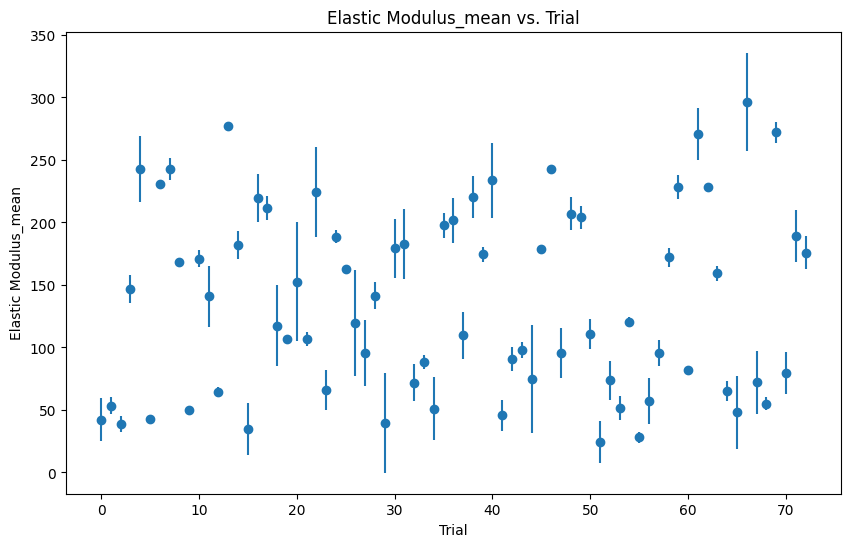

In [10]:
# shuffle the data 
data_grouped = data_grouped.sample(frac=1, random_state=42).reset_index(drop=True)
# plot Elastic Modulus_mean vs. a time axis, also add the error bars
plt.figure(figsize=(10, 6))
plt.errorbar(data_grouped.index, data_grouped['Elastic Modulus_mean'], yerr=data_grouped['Elastic Modulus_std'], fmt='o')
plt.xlabel('Trial')
plt.ylabel('Elastic Modulus_mean')
plt.title('Elastic Modulus_mean vs. Trial')
plt.show()
